# Setup

In [7]:
import os
import random
import datetime
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from numpy.linalg import cond
from typing import List

# Matrixlib
import matrixlib.blocking as blk
from matrixlib import preconditioning as prec
from matrixlib.core import MatrixData, ValueProperties, BlockProperties

#import CNN
import CNN.models
import CNN.training
import CNN.evaluation as eval

# Suppress tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set correct GPU device number environment variable
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

# Generate Synthetic Data
Generate a set of `n` square symmetrical and positive semi matrices of dimensions `MATRIX_DIM` to RAM.

## Define Constants
The following constants are used throughout the rest of the notebook.

In [82]:
MATRIX_DIM = 64
NUMBER_OF_MATRICES = 2000
DIAGONAL_BAND_RADIUS = 10
RNG_SEED = 42
VALUE_COLORBAR = 'rocket'
BLOCK_COLORBAR = 'flare'

initialized        data vectors of size   2000 x  64 x  64 =   8192000 with a memory usage of  31.250 MiB
initialized  data start vectors of size   2000 x  64       =    128000 with a memory usage of   0.122 MiB
initialized noise start vectors of size   2000 x  64       =    128000 with a memory usage of   0.122 MiB
initialized        band vectors of size   2000 x  64 x  10 =   1280000 with a memory usage of  10.254 MiB
--------------------------------------------------------------------------------
instantiation rng generators...
generating matrices...
invalid matrices: 0
determinant abs-value range: [0.020763317123055458, 4128080.25]


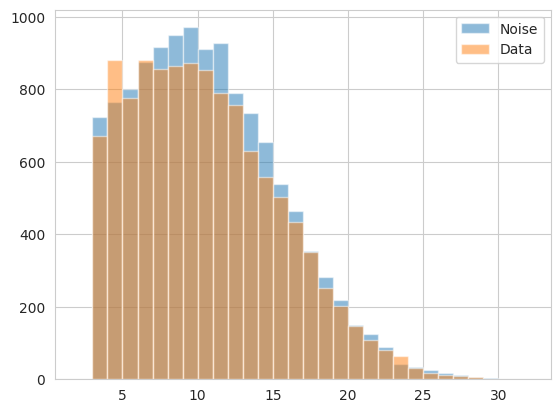

duration: 26.41 seconds


In [83]:
    # Generate matrices
bgr_noise_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.0, 0.5))
noise_blk_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.3, 1.0))
noise_blk_block_props = BlockProperties(size_range=(3, 32), size_average=10, size_std_dev=0.66, gap_chance=0.5)
tdata_blk_value_props = ValueProperties(density_range=(0.5, 0.7), value_range=(0.3, 1.0))
tdata_blk_block_props = BlockProperties(size_range=(2, 32), size_average=10, size_std_dev=0.66, gap_chance=0)

test_data = MatrixData(
        dimension=MATRIX_DIM,
        band_radius=DIAGONAL_BAND_RADIUS,
        sample_size=NUMBER_OF_MATRICES,
        background_noise_value_properties=bgr_noise_value_props,
        block_noise_value_properties=noise_blk_value_props,
        block_noise_block_properties=noise_blk_block_props,
        block_data_value_properties=tdata_blk_value_props,
        block_data_block_properties=tdata_blk_block_props,
        seed=42,
        determinant_cutoff=0.01,
        print_debug=True
    )

In [84]:
bands = test_data.bands.reshape(NUMBER_OF_MATRICES, (DIAGONAL_BAND_RADIUS* 2 + 1), MATRIX_DIM, 1)
bands = np.nan_to_num(bands) # replace NaNs with 0s
labels = test_data.tdata_blk_starts
print(f"Matrix Bands Shape: {bands.shape}, Matrix Labels Shape: {labels.shape}")

# Create dataset from matrices and labels
dataset = tf.data.Dataset.from_tensor_slices((bands, labels))

# Split the dataset
train_size = int(0.8 * NUMBER_OF_MATRICES)
val_size = int(0.1 * NUMBER_OF_MATRICES)
test_size = NUMBER_OF_MATRICES - train_size - val_size

train_dataset = dataset.take(train_size).shuffle(buffer_size=10)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

# Create test matrices and labels
test_matrices = test_data.matrices[train_size + val_size:]
test_labels = labels[train_size + val_size:]

# Verify Shape
print(f"Test Matrices Shape: {test_matrices.shape}, Test Labels Shape: {test_labels.shape}")
print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

# Verifiy datasets
print(train_dataset)
print(val_dataset)
print(test_dataset)

Matrix Bands Shape: (2000, 21, 64, 1), Matrix Labels Shape: (2000, 64)
Test Matrices Shape: (200, 64, 64), Test Labels Shape: (200, 64)
Train size: 1600, Val size: 200, Test size: 200
<_ShuffleDataset element_spec=(TensorSpec(shape=(21, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int8, name=None))>
<_TakeDataset element_spec=(TensorSpec(shape=(21, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int8, name=None))>
<_SkipDataset element_spec=(TensorSpec(shape=(21, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int8, name=None))>


# Training
run tensorboard --logdir logs to launch tensorboard

In [85]:
importlib.reload(CNN.training)
importlib.reload(CNN.models)
importlib.reload(CNN.evaluation)

# Define parameters
loss_fn = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.00001)
input_shape = (DIAGONAL_BAND_RADIUS * 2 + 1, MATRIX_DIM, 1)
# class_weights = {0: 0.1, 1: 0.9}
num_epochs = 20

# Create log dir
log_dir = "logs/CNN/hundred/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
print("Files in log directory:", os.listdir(log_dir))

def set_seeds(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seeds()

# Compile Model
model = CNN.models.Baseline(input_shape)

# Start Training Loop
trained_model, train_losses, val_losses = CNN.training.train_model(
    model=model,
    train_dataset=train_dataset.batch(4),  # Adjust when connected to vm
    val_dataset=val_dataset.batch(4),
    loss_fn=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    log_dir=log_dir    
)

Files in log directory: []
Epoch 1/20


KeyboardInterrupt: 

In [ ]:
# Plot losses
CNN.training.plot_losses(train_losses, val_losses)

# Evaluation

In [ ]:
# Evaluate the model on the test set
evaluation_results = CNN.evaluation.evaluate_model(
    model=trained_model,
    test_dataset=test_dataset.batch(4),
    loss_fn=loss_fn
)

# Restore Best Model Weights

In [86]:
importlib.reload(CNN.models)
importlib.reload(CNN.evaluation)

# Define parameters
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.00001)
input_shape = (DIAGONAL_BAND_RADIUS * 2 + 1, MATRIX_DIM, 1)

# Restore weights from best run
new_model = CNN.models.Baseline(input_shape)
new_model.build((None,) + input_shape)  # None represents the batch dimension
new_model.load_weights("BestBaseline_final.weights.h5")
   
# Evaluate the restored model
new_results = CNN.evaluation.evaluate_model(
    model=new_model,
    test_dataset=test_dataset.batch(4),
    loss_fn=loss_fn
)

Test Loss: 0.1601
Element-wise Accuracy: 0.944375
Classification Report:
              precision    recall  f1-score   support

    no block       0.95      0.99      0.97     11487
       block       0.88      0.53      0.66      1313

    accuracy                           0.94     12800
   macro avg       0.92      0.76      0.82     12800
weighted avg       0.94      0.94      0.94     12800

Confusion Matrix:
[[11396    91]
 [  621   692]]
True Positives: 692
False Negatives: 621
True Negatives: 11396
False Positives: 91


2024-06-24 03:22:25.534619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Prediction

In [87]:
importlib.reload(eval)
test_predictions = new_model.predict(test_dataset.batch(8))

# Convert to Binary
threshold = 0.5
binary_predictions = (test_predictions >= threshold).astype(int)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


# Create Preconditioner from Supervariable Blocking
## 1. Find supervariables (sharing the same sparsity pattern)
## 2- Extract indicator of block starts
## 3. Feed into preconditioner from predictions function

In [88]:
import matrixlib.blocking as blk
importlib.reload(blk)
importlib.reload(prec)
importlib.reload(eval)

block_starts = blk.supervariable_blocking(test_matrices, 32)
metrics_svblocking = CNN.evaluation.calculate_metrics(test_labels, block_starts)

Element-wise Accuracy: 0.871171875
Classification Report:
              precision    recall  f1-score   support

    no block       0.90      0.97      0.93     11487
       block       0.08      0.02      0.04      1313

    accuracy                           0.87     12800
   macro avg       0.49      0.50      0.48     12800
weighted avg       0.81      0.87      0.84     12800

Confusion Matrix:
[[11119   368]
 [ 1281    32]]
True Positives: 32
False Negatives: 1281
True Negatives: 11119
False Positives: 368



# Create Preconditioner from predicted block starts
### 1. Form Blocks from Predictions
### 2. Invert Blocks (ensure non-singularity)
### 3. Create Block Diagonal Matrix



In [115]:
importlib.reload(prec)

# Define variables
A_original = test_matrices
A_flipped = np.array([prec.prepare_matrix(test_matrices[i], method='flip') for i in range(test_matrices.shape[0])])
A_shifted = np.array([prec.prepare_matrix(test_matrices[i], method='shift') for i in range(test_matrices.shape[0])])
A_minmax = np.array([prec.prepare_matrix(test_matrices[i], method='minmax') for i in range(test_matrices.shape[0])])

print("Preconditioner from True Block Starts")
precs_true = prec.block_jacobi_preconditioner_from_predictions(test_matrices, test_labels)
print("Preconditioner from Predicted Block Starts")
precs_cnn = prec.block_jacobi_preconditioner_from_predictions(test_matrices, binary_predictions)
print("Preconditioner from Supervariable Blocking")
precs_sv = prec.block_jacobi_preconditioner_from_predictions(test_matrices, block_starts)

b = np.ones((test_matrices.shape[0], test_matrices.shape[1]))

Preconditioner from True Block Starts
Matrix is singular, using pseudo-inverse for block 23 at indices 61:64
Matrix is singular, using pseudo-inverse for block 26 at indices 60:64
Matrix is singular, using pseudo-inverse for block 27 at indices 61:64
Matrix is singular, using pseudo-inverse for block 28 at indices 60:64
Matrix is singular, using pseudo-inverse for block 29 at indices 62:64
Matrix is singular, using pseudo-inverse for block 58 at indices 61:64
Matrix is singular, using pseudo-inverse for block 63 at indices 37:39
Matrix is singular, using pseudo-inverse for block 70 at indices 62:64
Matrix is singular, using pseudo-inverse for block 71 at indices 60:64
Matrix is singular, using pseudo-inverse for block 78 at indices 10:12
Matrix is singular, using pseudo-inverse for block 81 at indices 61:64
Preconditioner from Predicted Block Starts
Matrix is singular, using pseudo-inverse for block 27 at indices 61:64
Matrix is singular, using pseudo-inverse for block 70 at indices 59

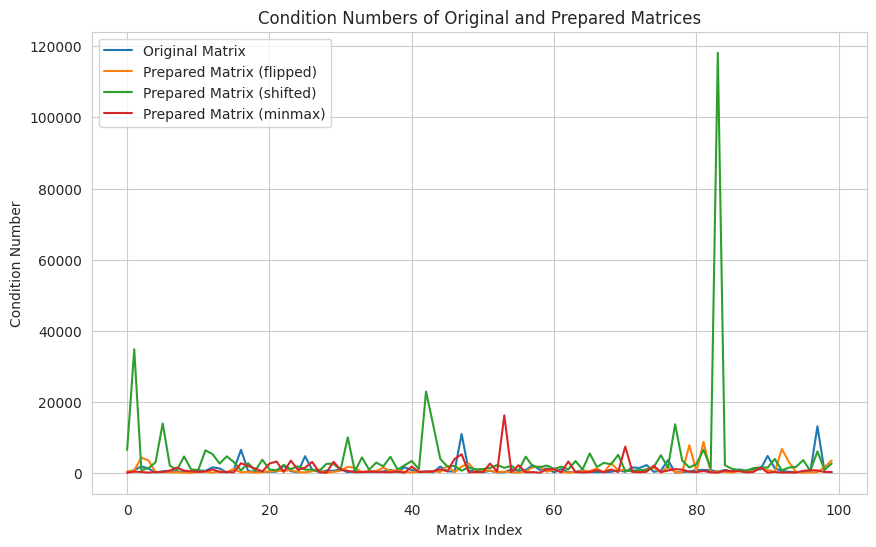

In [116]:
 # plot condition numbers 
plt.figure(figsize=(10, 6))
plt.plot([np.linalg.cond(A_original[i]) for i in range(A_original.shape[0])], label='Original Matrix')
plt.plot([np.linalg.cond(A_flipped[i]) for i in range(A_flipped.shape[0])], label='Prepared Matrix (flipped)')
plt.plot([np.linalg.cond(A_shifted[i]) for i in range(A_shifted.shape[0])], label='Prepared Matrix (shifted)')
plt.plot([np.linalg.cond(A_minmax[i]) for i in range(A_minmax.shape[0])], label='Prepared Matrix (minmax)')
plt.xlabel('Matrix Index')
plt.ylabel('Condition Number')
plt.title('Condition Numbers of Original and Prepared Matrices')
plt.legend()
plt.show()

# Run GMRES Solver:
 ### - Without Preconditioner 
    - With original Matrices
    - With flipped Matrices
    - With scaled Matrices
    - With shifted Matrices
 ### - With Preconditioner created from true block starts
    - With original Matrices
    - With flipped Matrices
    - With scaled Matrices
    - With shifted Matrices
    
 ### - With Preconditioner created from predicted block starts 
    - With original Matrices
    - With flipped Matrices
    - With scaled Matrices
    - With shifted Matrices
 
 ## - With Preconditioner created from Supervariable Blocking 
    - With original Matrices
    - With flipped Matrices
    - With scaled Matrices
    - With shifted Matrices
    

In [117]:
importlib.reload(prec)

# Solve without precodntitioner
input_matrices_list = [
    ('Original Matrices', A_original),
    ('Flipped Matrices', A_flipped),
    ('Scaled Matrices', A_minmax),
    ('Shifted Matrices', A_shifted)
]
preconditioners_list = [
    ('No Preconditioner', None),
    ('Prec from True Block Starts', precs_true),
    ('Prec from Predicted Block Starts', precs_cnn),
    ('Prec from Supervariable Blocking', precs_sv)
]

results = []

for input_name, input_matrices in input_matrices_list:
    for prec_name, preconditioner_source in preconditioners_list:
        print(f"Solving {input_name} with {prec_name}")
        x, info, iters, residuals = prec.solve_with_gmres_monitored(input_matrices, b, preconditioner_source)        
        
        results.append({
            'Matrix Type': input_name,
            'Preconditioner Type': prec_name,
            'Iterations': iters            
        })


Solving Original Matrices with No Preconditioner
  Converged: 91 out of 100
  Average iterations: 3919.74
Solving Original Matrices with Prec from True Block Starts
  Converged: 77 out of 100
  Average iterations: 4614.41
Solving Original Matrices with Prec from Predicted Block Starts
  Converged: 62 out of 100
  Average iterations: 6249.49
Solving Original Matrices with Prec from Supervariable Blocking
  Converged: 63 out of 100
  Average iterations: 6446.85
Solving Flipped Matrices with No Preconditioner
  Converged: 93 out of 100
  Average iterations: 3243.93
Solving Flipped Matrices with Prec from True Block Starts
  Converged: 90 out of 100
  Average iterations: 2665.02
Solving Flipped Matrices with Prec from Predicted Block Starts
  Converged: 84 out of 100
  Average iterations: 3505.55
Solving Flipped Matrices with Prec from Supervariable Blocking
  Converged: 89 out of 100
  Average iterations: 3220.28
Solving Scaled Matrices with No Preconditioner
  Converged: 95 out of 100
  

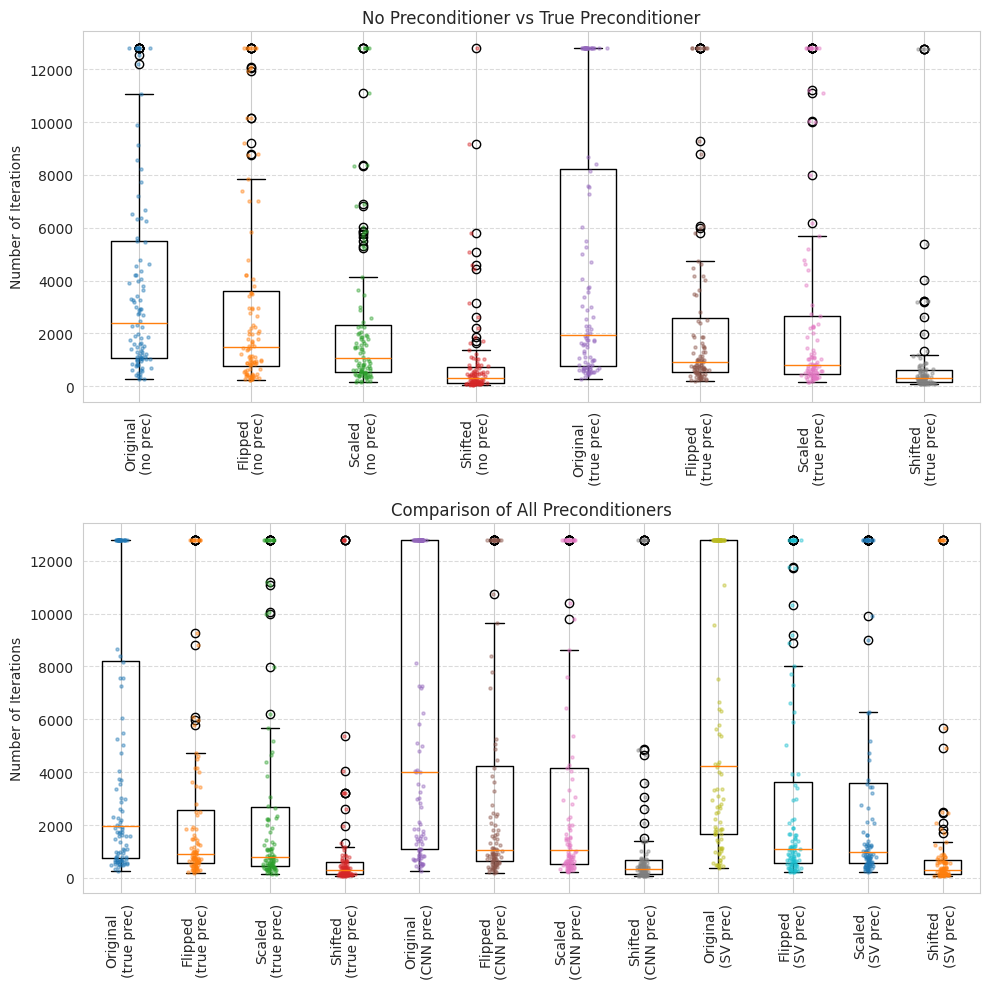

In [150]:
# Unpack results for each combination of matrix type and preconditioner type for boxplot 
iters_no_prec_original = [result['Iterations'] for result in results if result['Matrix Type'] == 'Original Matrices' and result['Preconditioner Type'] == 'No Preconditioner']
iters_no_prec_flipped = [result['Iterations'] for result in results if result['Matrix Type'] == 'Flipped Matrices' and result['Preconditioner Type'] == 'No Preconditioner']
iters_no_prec_minmax = [result['Iterations'] for result in results if result['Matrix Type'] == 'Scaled Matrices' and result['Preconditioner Type'] == 'No Preconditioner']
iters_no_prec_shifted = [result['Iterations'] for result in results if result['Matrix Type'] == 'Shifted Matrices' and result['Preconditioner Type'] == 'No Preconditioner']
iters_prec_true_original = [result['Iterations'] for result in results if result['Matrix Type'] == 'Original Matrices' and result['Preconditioner Type'] == 'Prec from True Block Starts']
iters_prec_true_flipped = [result['Iterations'] for result in results if result['Matrix Type'] == 'Flipped Matrices' and result['Preconditioner Type'] == 'Prec from True Block Starts']
iters_prec_true_minmax = [result['Iterations'] for result in results if result['Matrix Type'] == 'Scaled Matrices' and result['Preconditioner Type'] == 'Prec from True Block Starts']
iters_prec_true_shifted = [result['Iterations'] for result in results if result['Matrix Type'] == 'Shifted Matrices' and result['Preconditioner Type'] == 'Prec from True Block Starts']
iters_prec_cnn_original = [result['Iterations'] for result in results if result['Matrix Type'] == 'Original Matrices' and result['Preconditioner Type'] == 'Prec from Predicted Block Starts']
iters_prec_cnn_flipped = [result['Iterations'] for result in results if result['Matrix Type'] == 'Flipped Matrices' and result['Preconditioner Type'] == 'Prec from Predicted Block Starts']
iters_prec_cnn_minmax = [result['Iterations'] for result in results if result['Matrix Type'] == 'Scaled Matrices' and result['Preconditioner Type'] == 'Prec from Predicted Block Starts']
iters_prec_cnn_shifted = [result['Iterations'] for result in results if result['Matrix Type'] == 'Shifted Matrices' and result['Preconditioner Type'] == 'Prec from Predicted Block Starts']
iters_prec_sv_original = [result['Iterations'] for result in results if result['Matrix Type'] == 'Original Matrices' and result['Preconditioner Type'] == 'Prec from Supervariable Blocking']
iters_prec_sv_flipped = [result['Iterations'] for result in results if result['Matrix Type'] == 'Flipped Matrices' and result['Preconditioner Type'] == 'Prec from Supervariable Blocking']
iters_prec_sv_minmax = [result['Iterations'] for result in results if result['Matrix Type'] == 'Scaled Matrices' and result['Preconditioner Type'] == 'Prec from Supervariable Blocking']
iters_prec_sv_shifted = [result['Iterations'] for result in results if result['Matrix Type'] == 'Shifted Matrices' and result['Preconditioner Type'] == 'Prec from Supervariable Blocking']

def prepare_data(data_list):
    if not data_list:  # If the list is empty
        return [0]  # Return a list with a single zero
    data_array = np.array(data_list)
    if data_array.ndim > 2:
        data_array = data_array.reshape(-1)  # Flatten to 1D
    elif data_array.ndim == 2:
        data_array = data_array.flatten()
    return data_array.tolist()

# Prepare all data lists
data_lists_1 = [
    iters_no_prec_original, iters_no_prec_flipped, iters_no_prec_minmax, iters_no_prec_shifted,
    iters_prec_true_original, iters_prec_true_flipped, iters_prec_true_minmax, iters_prec_true_shifted
]

data_lists_2 = [
    iters_prec_true_original, iters_prec_true_flipped, iters_prec_true_minmax, iters_prec_true_shifted,
    iters_prec_cnn_original, iters_prec_cnn_flipped, iters_prec_cnn_minmax, iters_prec_cnn_shifted,
    iters_prec_sv_original, iters_prec_sv_flipped, iters_prec_sv_minmax, iters_prec_sv_shifted
]

prepared_data_1 = [prepare_data(data) for data in data_lists_1]
prepared_data_2 = [prepare_data(data) for data in data_lists_2]

# Create two separate figures
plt.figure(figsize=(10,10))

# First boxplot: No preconditioner and True preconditioner
plt.subplot(2, 1, 1)
bp1 = plt.boxplot(
    prepared_data_1,
    tick_labels=[
        'Original\n(no prec)', 'Flipped\n(no prec)', 'Scaled\n(no prec)', 'Shifted\n(no prec)',
        'Original\n(true prec)', 'Flipped\n(true prec)', 'Scaled\n(true prec)', 'Shifted\n(true prec)'
    ]
)

plt.title('No Preconditioner vs True Preconditioner')
plt.ylabel('Number of Iterations')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)

for i, data in enumerate(prepared_data_1):
    x = np.random.normal(i+1, 0.04, size=len(data))
    plt.scatter(x, data, alpha=0.4, s=5, zorder=2)

# Second boxplot: All preconditioners
plt.subplot(2, 1, 2)
bp2 = plt.boxplot(
    prepared_data_2,
    tick_labels=[
        'Original\n(true prec)', 'Flipped\n(true prec)', 'Scaled\n(true prec)', 'Shifted\n(true prec)',
        'Original\n(CNN prec)', 'Flipped\n(CNN prec)', 'Scaled\n(CNN prec)', 'Shifted\n(CNN prec)',
        'Original\n(SV prec)', 'Flipped\n(SV prec)', 'Scaled\n(SV prec)', 'Shifted\n(SV prec)'
    ]
)

plt.title('Comparison of All Preconditioners')
plt.ylabel('Number of Iterations')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)

for i, data in enumerate(prepared_data_2):
    x = np.random.normal(i+1, 0.04, size=len(data))
    plt.scatter(x, data, alpha=0.4, s=5, zorder=2)

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

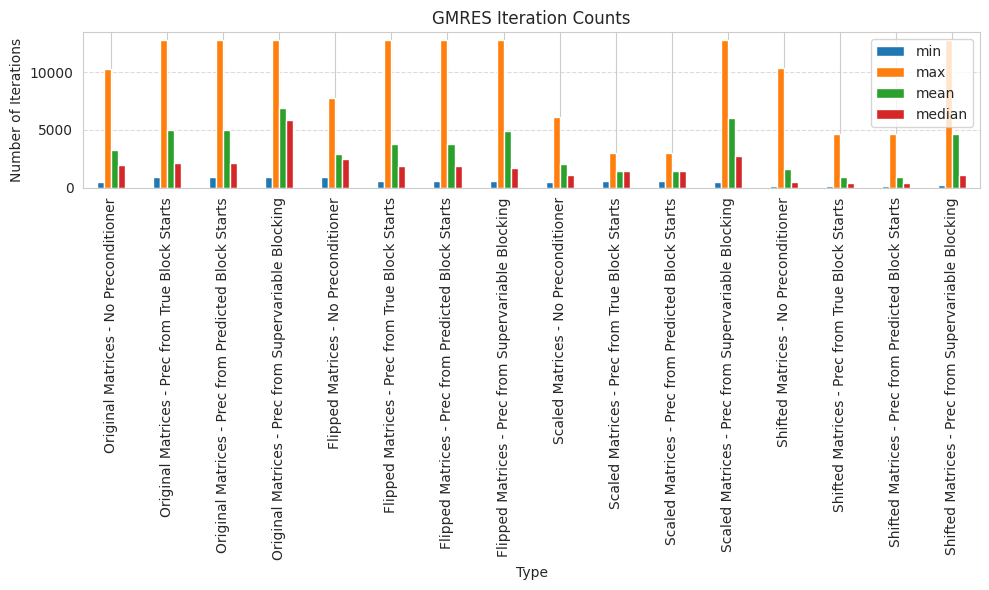

In [102]:
# Calculate statistics for iteration counts
def iter_stats(iters):
    return {        
        'min': np.min(iters),
        'max': np.max(iters),
        'mean': np.mean(iters),
        'median': np.median(iters)
    }

# print stats
results_df = pd.DataFrame(results)

Iteration count statistics:
Original (no preconditioner): {'min': 268, 'max': 12800, 'mean': 3919.74, 'median': 2383.5}
Prepared (no preconditioner): {'min': 54, 'max': 12800, 'mean': 867.4, 'median': 307.5}
Prepared (with preconditioner): {'min': 64, 'max': 12786, 'mean': 1057.23, 'median': 312.0}
Prepared minmax (with preconditioner): {'min': 160, 'max': 12800, 'mean': 2912.58, 'median': 794.5}


/tmp/ipykernel_5196/3908266231.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot([iters_no_prec_original, iters_no_prec, iters_prec, iters_prec_minmax],


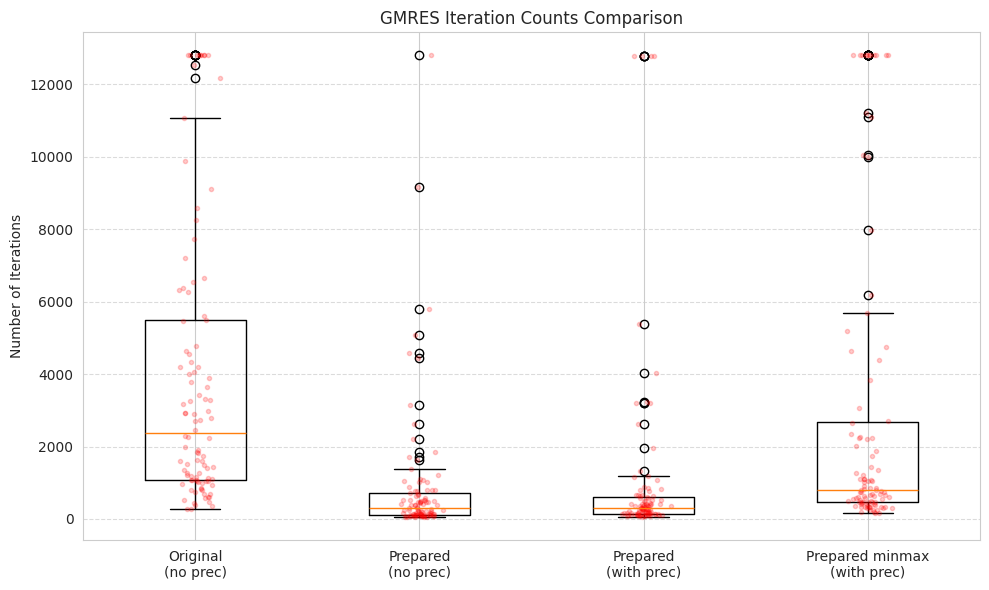

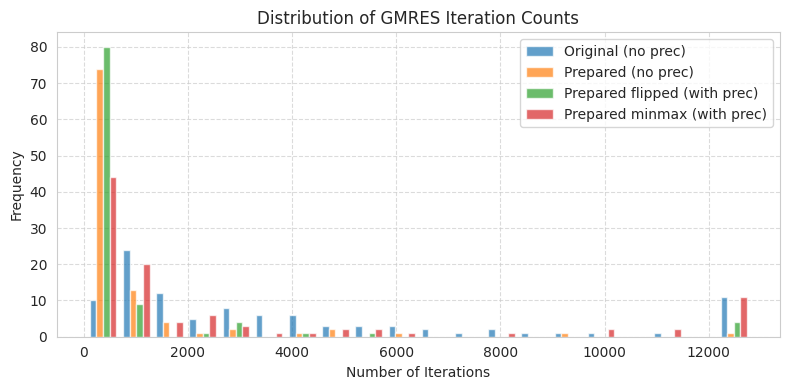

In [54]:
# Create box plots
plt.figure(figsize=(10, 6))
bp = plt.boxplot([iters_no_prec_original, iters_no_prec, iters_prec, iters_prec_minmax], 
                 labels=['Original\n(no prec)', 'Prepared\n(no prec)', 'Prepared\n(with prec)', 'Prepared minmax\n(with prec)'])

plt.title('GMRES Iteration Counts Comparison')
plt.ylabel('Number of Iterations')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add some jitter to the data points
for i, data in enumerate([iters_no_prec_original, iters_no_prec, iters_prec, iters_prec_minmax], 1):
    x = np.random.normal(i, 0.04, size=len(data))
    plt.plot(x, data, 'r.', alpha=0.2)

plt.tight_layout()
plt.show()

# Histogram
plt.figure(figsize=(8, 4))
plt.hist([iters_no_prec_original, iters_no_prec, iters_prec, iters_prec_minmax], 
         label=['Original (no prec)', 'Prepared (no prec)', 'Prepared flipped (with prec)', 'Prepared minmax (with prec)'],
         bins=20, alpha=0.7)
plt.xlabel('Number of Iterations')
plt.ylabel('Frequency')
plt.title('Distribution of GMRES Iteration Counts')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

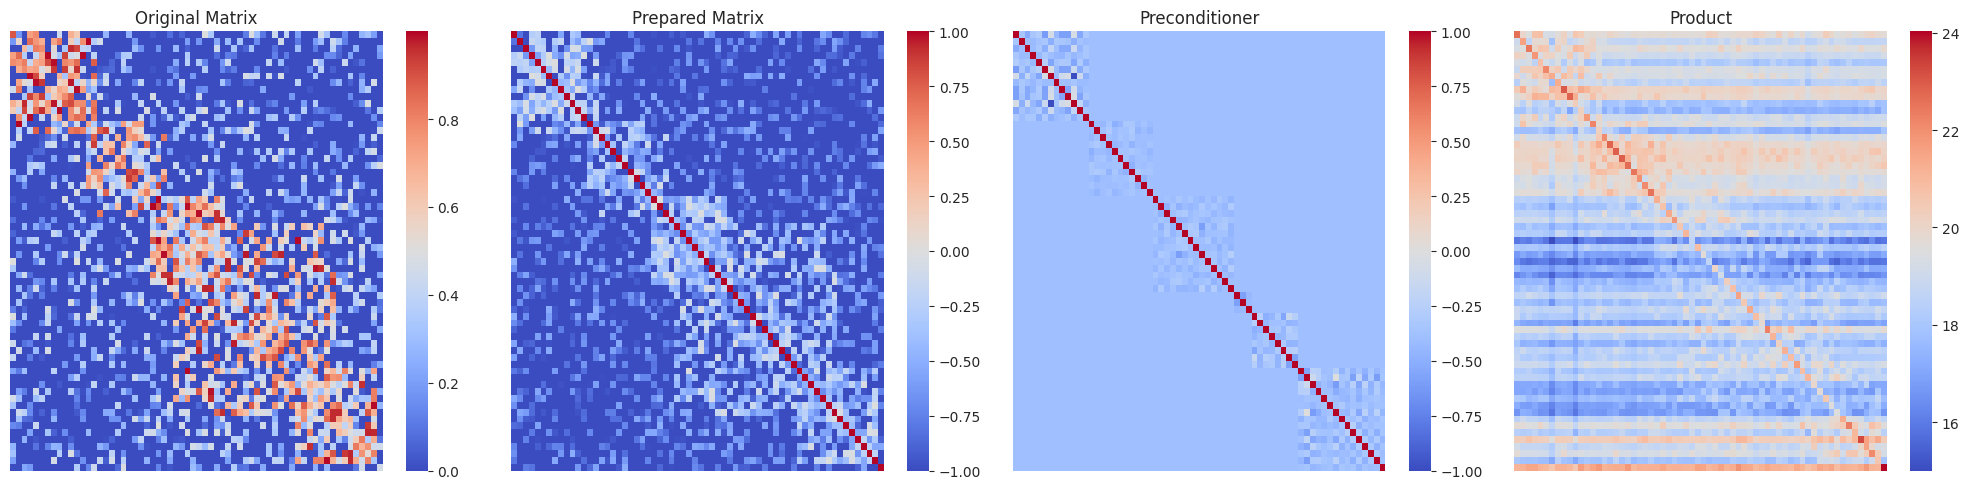

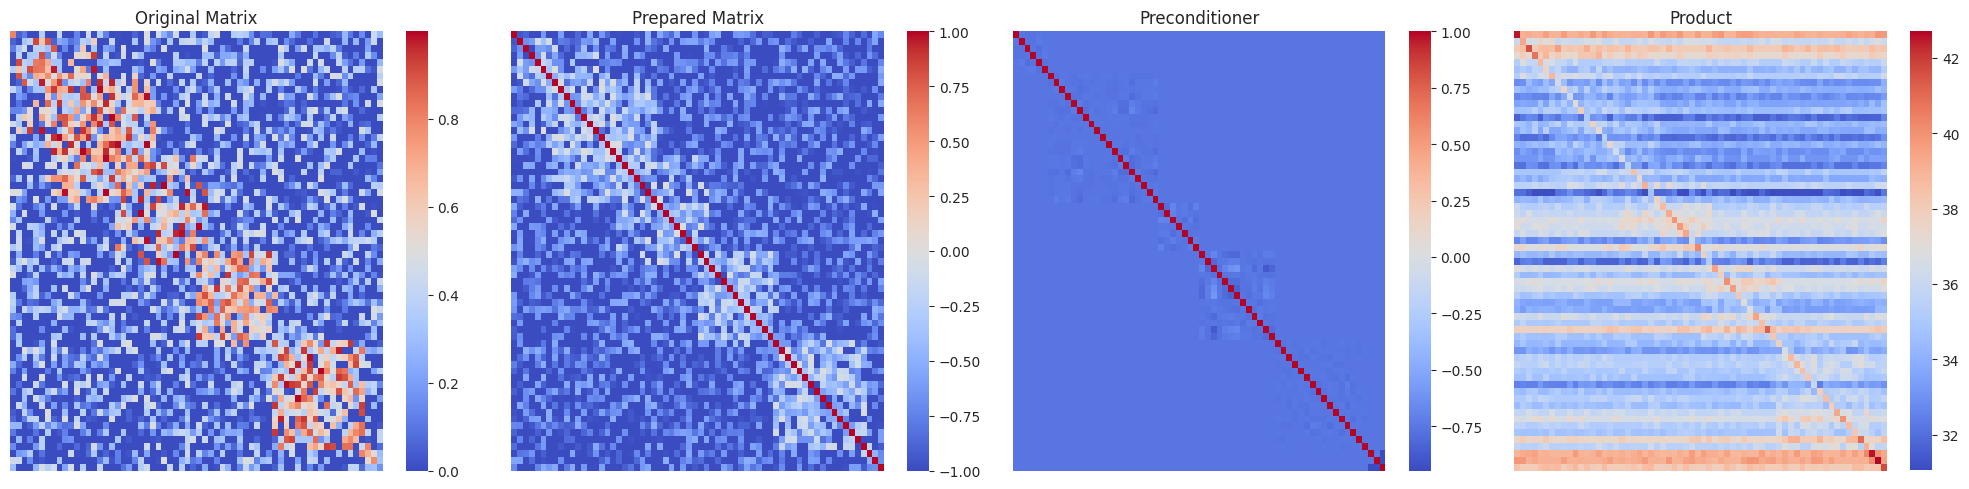

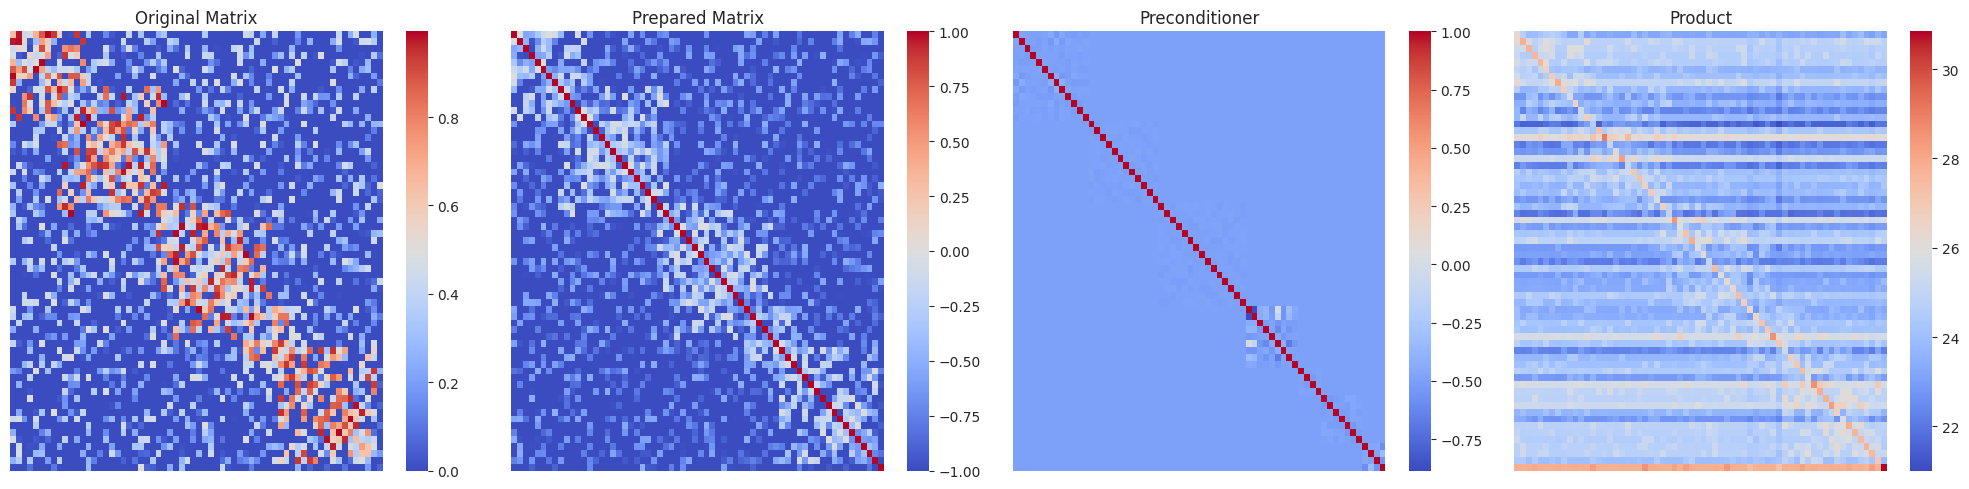

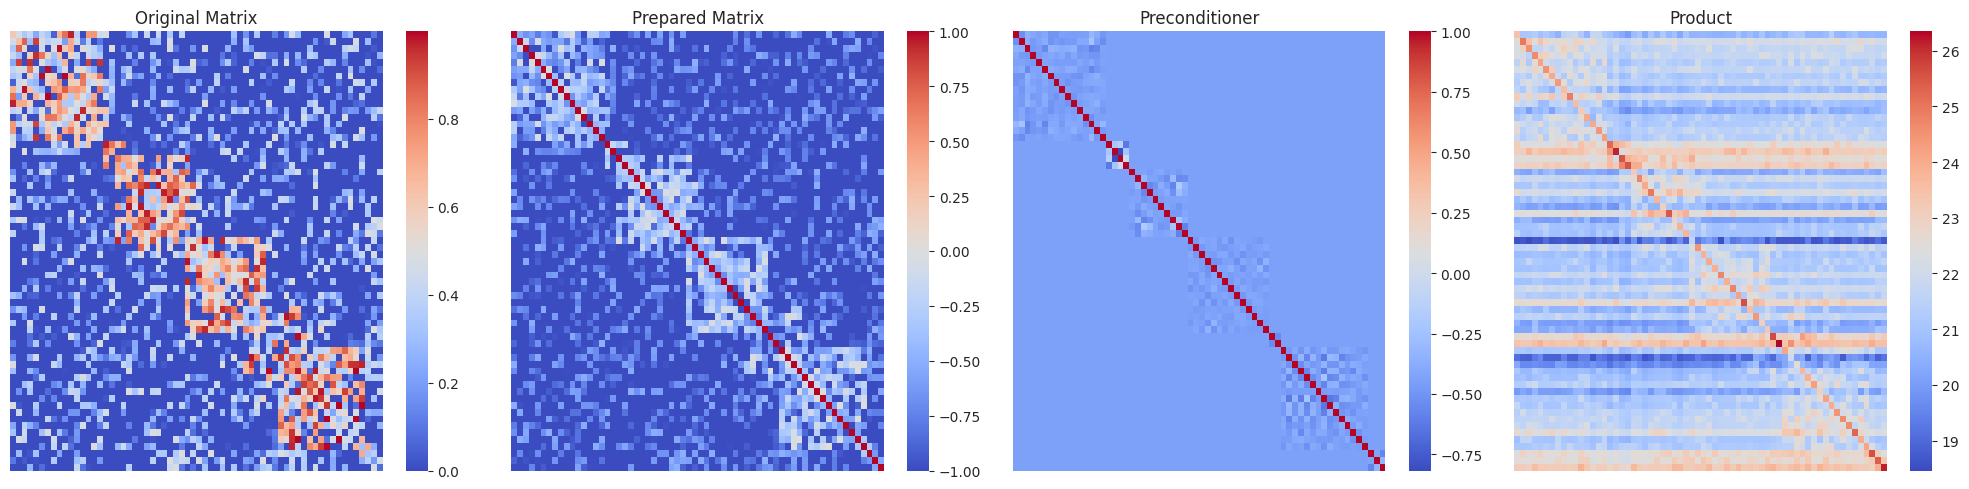

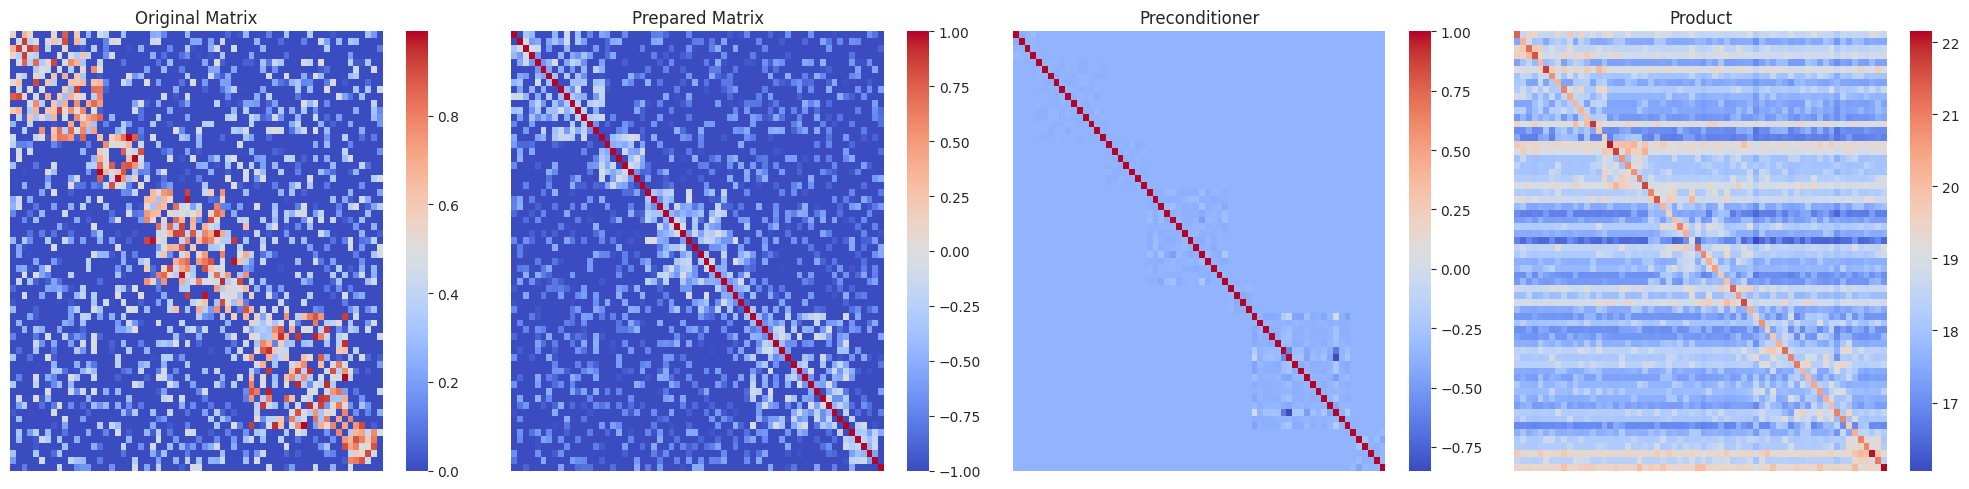

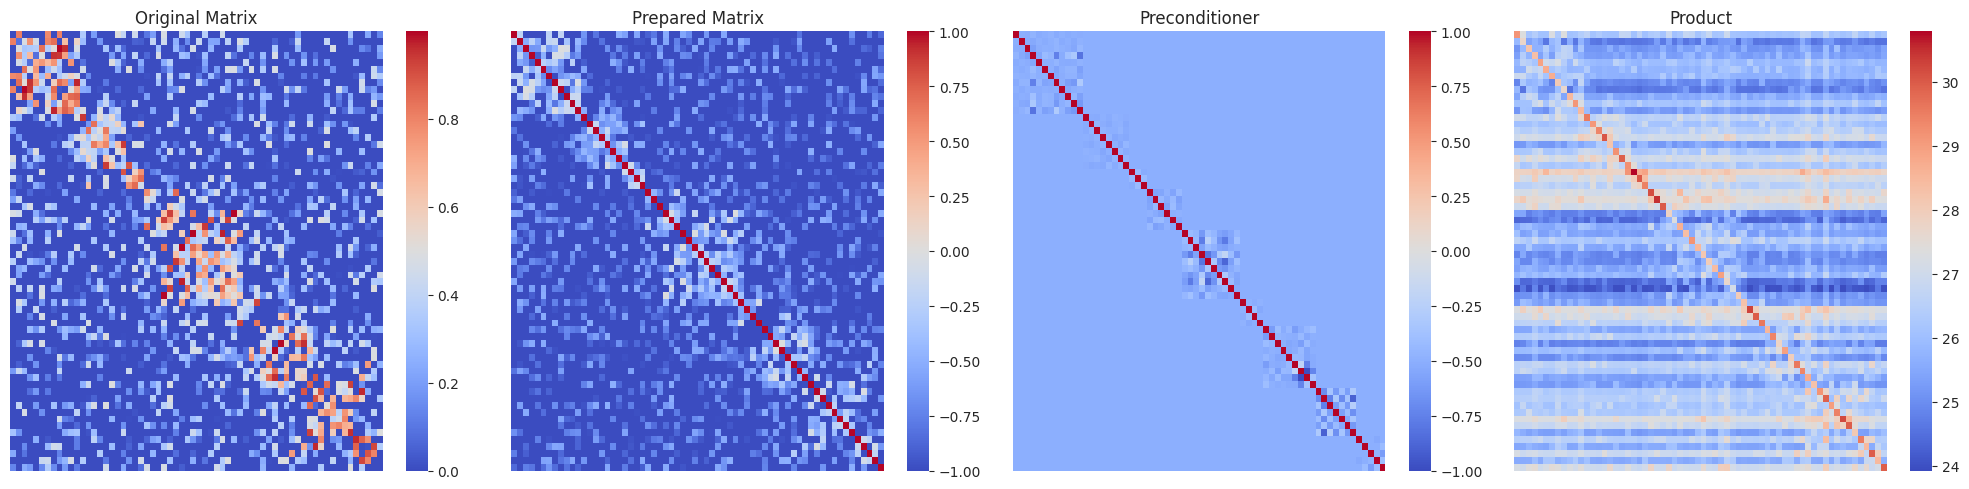

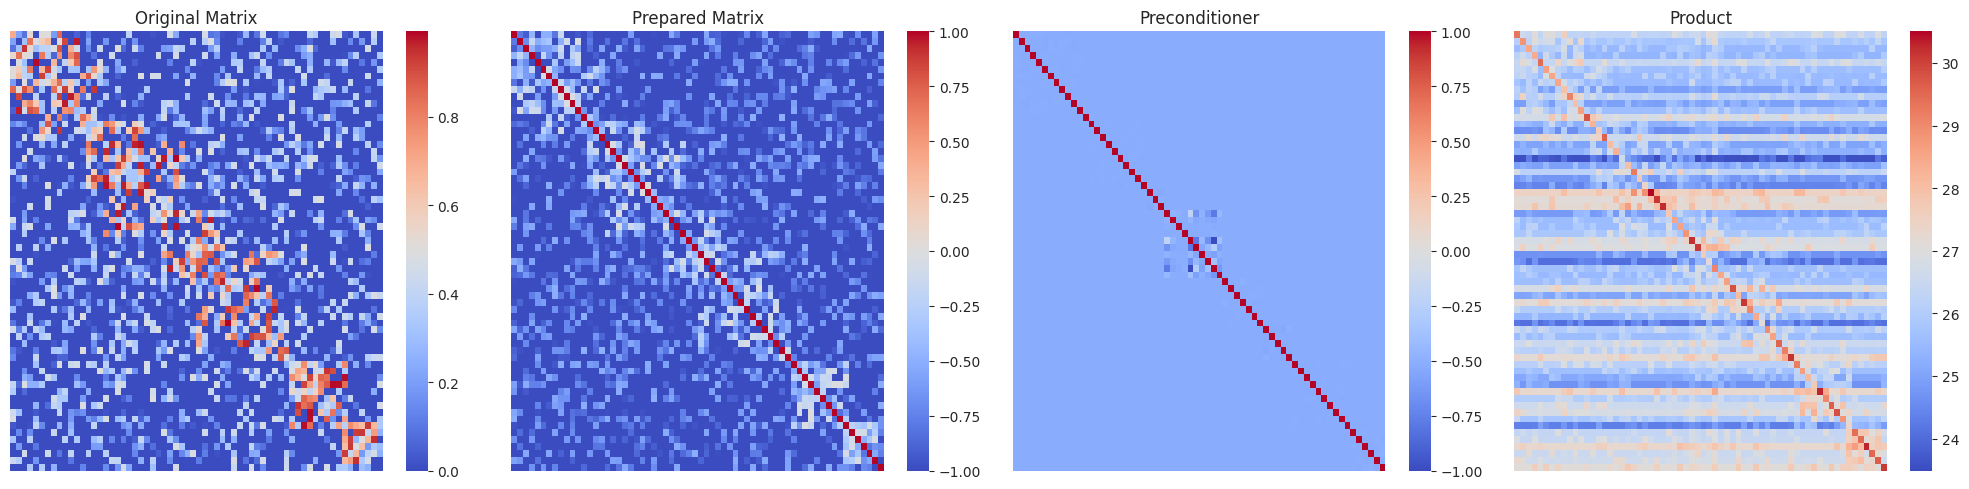

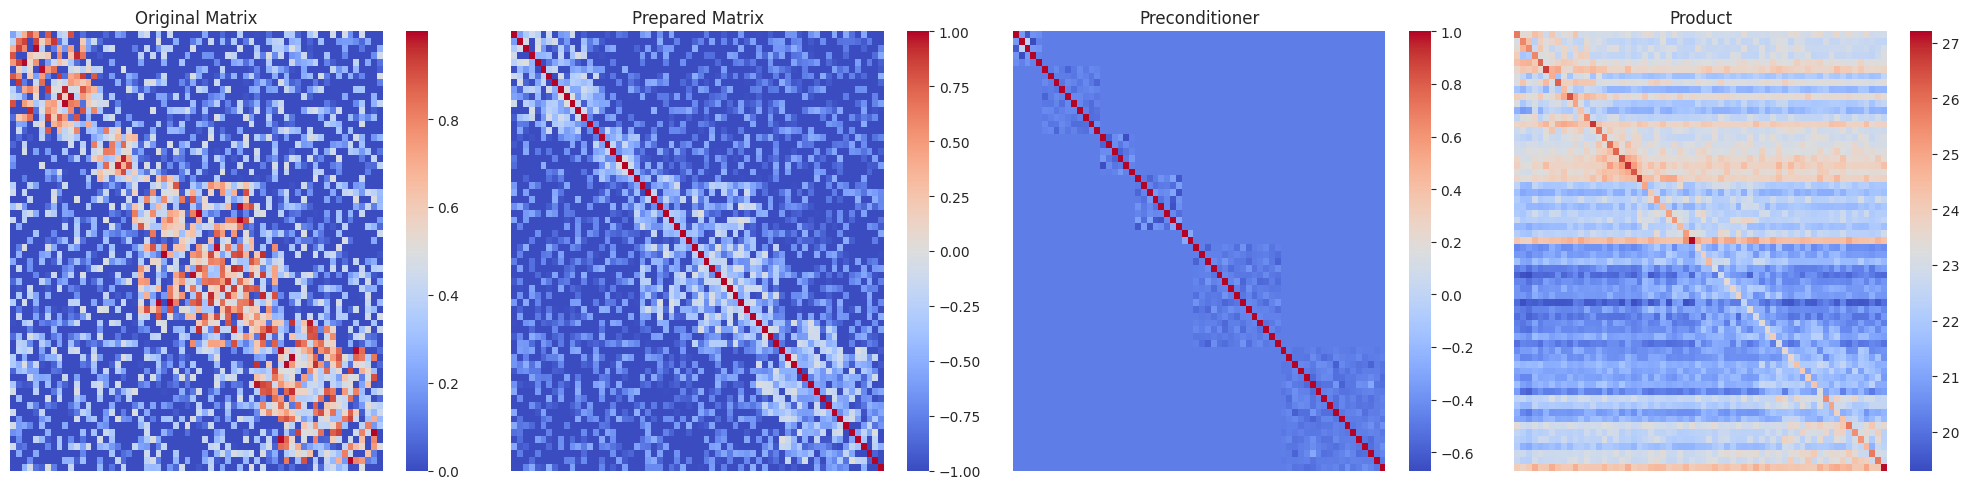

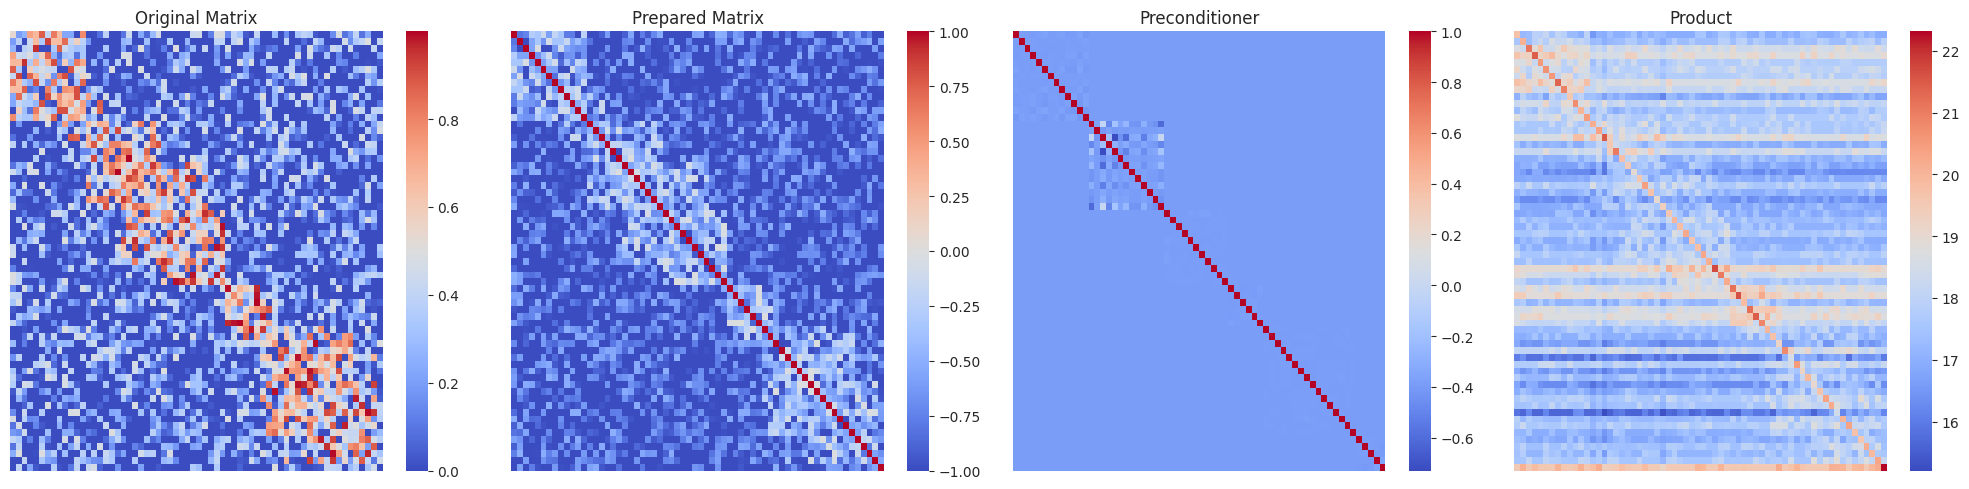

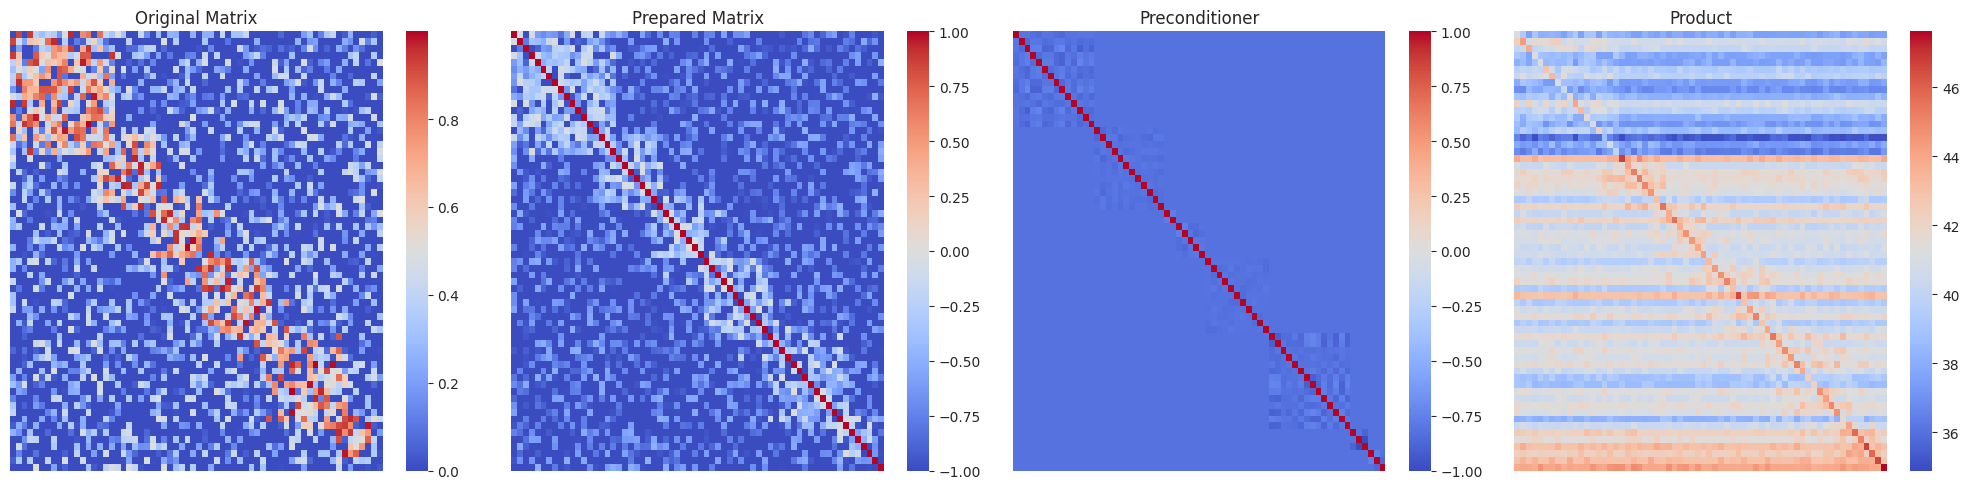

In [53]:
# Function to plot matrices
def plot_matrices(matrices: List[np.ndarray], titles: List[str], colorbar: str = VALUE_COLORBAR) -> None:
    num_matrices = len(matrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=(5 * num_matrices, 5))

    for i, (matrix, title) in enumerate(zip(matrices, titles)):
        ax = axes[i] if num_matrices > 1 else axes
        sns.heatmap(matrix, cmap=colorbar, ax=ax, cbar=True)
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()
    
# Plot matrices
for i in range(10):
    plot_matrices(
        [test_matrices[i], A[i], precs[i], np.matmul(A[i], precs[i])], 
        ['Original Matrix', 'Prepared Matrix', 'Preconditioner', 'Product'], 
        colorbar='coolwarm'
    )